In [1]:
from game_parameters import NUM_COINS, NUM_FORAGERS, IMAGE_PATHS

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from numpy.typing import NDArray
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from typing import List, Tuple, Optional, Iterable, Union, Any

In [5]:
class World:
    """2D grid world with coins placed according to a distribution.

    Grid cells contain 1 if a coin is present, otherwise 0.
    """
    width: Optional[int] = 100
    height: Optional[int] = 100
    seed: Optional[int] = None
    coin_path: Path = None
    map_path: Path = None
    forager_path = None
    num_foragers: int = NUM_FORAGERS
    forager_positions: List[Tuple[int, int]] = []
    forager_queue: List[Tuple[int, Tuple[int, int]]] = []

    def __init__(
        self,
        num_coins: int,
        num_centroids: int,
        distribution: str,
        dispersion: float,
    ) -> None:
        self.num_coins = num_coins
        self.num_centroids = num_centroids
        assert(distribution in ["linear", "circular", "oval"]), f"Dispersion {distribution} not supported. Choose from ['linear', 'circular', 'oval']."
        self.distribution = distribution
        assert(dispersion > 0), f"Dispersion must be greater than 0 (but got {dispersion})."
        self.dispersion = dispersion
        if self.width <= 0 or self.height <= 0:
            raise ValueError("width and height must be positive.")
        if self.num_coins < 0:
            raise ValueError("num_coins must be non-negative.")
        if self.num_coins > self.width * self.height / 10:
            raise ValueError(f"num_coins cannot exceed {int(self.width * self.height / 10)} (but got {self.num_coins})")
        self._rng = np.random.default_rng(self.seed if self.seed is not None else 42)
        self.grid = np.zeros((self.width, self.height))
        self._place_coins()

    def add_forager_position(self, position:Tuple[int, int]) -> None:
        forager_id = len(self.forager_positions)
        self.forager_positions.append(position)
        self.forager_queue.append((forager_id, position))

    def get_forager_position(self) -> Tuple[int, Tuple[int, int]]:
        forager_id, position = self.forager_queue.pop(0)
        return forager_id, position

    def coin_positions(self) -> List[Tuple[int, int]]:
        """List of (row, col) positions where coins are present."""
        coords_x, coords_y = np.where(self.grid == 1)
        coin_positions = list(zip(coords_x.tolist(), coords_y.tolist()))
        return coin_positions

    def count_coins(self) -> int:
        """Return the number of coins currently placed."""
        return self.grid.sum()

    def clear(self) -> None:
        """Remove all coins (set all cells to 0)."""
        self.grid = np.zeros((self.width, self.height))

    def _place_coins(self) -> None:
        """Dispatch to the chosen distribution strategy."""
        self.clear()
        if self.num_coins == 0:
            return

        coins_per_centroid = self.num_coins // self.num_centroids
        offset = self.count_coins() - coins_per_centroid * self.num_centroids
        coins_per_centroid = [coins_per_centroid for _ in range(self.num_centroids)]
        if offset > 0:
            coins_per_centroid[-1] += offset

        centroids = self.get_centroids()
        for i, (x, y) in enumerate(centroids):
            n_coins = coins_per_centroid[i]
            sample_coins = self.sample_bivariate_normal(
                mean=(x, y),
                cov=((self.dispersion, 0), (0, self.dispersion)),
                n=n_coins,
            )
            coords_x = [int(x) for x, y in sample_coins]
            coords_y = [int(y) for x, y in sample_coins]
            self.grid[coords_x, coords_y] = 1

    def get_centroids(self) -> List[Tuple[int, int]]:
        """Return the centroids of coins placed."""
        if self.num_centroids == 1:
            return [(int(self.width / 2), int(self.height / 2))]

        if self.distribution == "linear":
            sample = np.linspace(0, 1, self.num_centroids + 2)[1:-1]
            sample = [(int(x * self.width), int(x * self.height)) for x in sample]
            return sample

        elif self.distribution == "circular":
            sample = np.linspace(0, 1, self.num_centroids + 1)[:-1]
            theta = (2.0 * np.pi) * sample
            x = np.cos(theta).tolist()
            y = np.sin(theta).tolist()
            sample = list(zip(x, y))

            x_scale = 0.25 * self.width
            y_scale = 0.25 * self.height
            sample = [(x * x_scale, y * y_scale) for x, y in sample]
            sample = [(x + 0.5 * self.width, y + 0.5 * self.height) for x, y in sample]
            sample = [(int(x), int(y)) for x, y in sample]
            return sample

        elif self.distribution == "oval":
            raise NotImplementedError("oval dispersion is not yet implemented.")

        else:
            raise NotImplementedError(f"Dispersion {self.distribution} not supported. Choose from ['linear', 'circular', 'oval'].")

    def __str__(self) -> str:
        """ASCII representation: '1' for coin, '.' for empty."""
        lines = []
        for r in range(self.height):
            line = "".join("1" if self.grid[r][c] else "." for c in range(self.width))
            lines.append(line)
        return "\n".join(lines)

    def sample_bivariate_normal(
        self,
        mean: Iterable[float],
        cov: Iterable[Iterable[float]],
        n: int,
    ) -> List[Tuple[float, float]] | NDArray[np.float64]:
        """
        Sample n points from a 2D (bivariate) normal distribution.

        Parameters
        ----------
        n : int
            Number of samples.
        mean : Iterable[float]
            Length-2 mean vector [mu_x, mu_y].
        cov : Iterable[Iterable[float]]
            2x2 covariance matrix [[var_x, cov_xy], [cov_yx, var_y]].

        Returns
        -------
        List[Tuple[float, float]] | NDArray[np.float_]
            The sampled coordinates.
        """
        mean_arr = np.asarray(mean, dtype=float)
        cov_arr = np.asarray(cov, dtype=float)

        samples: NDArray[np.float64] = self._rng.multivariate_normal(
            mean=mean_arr,
            cov=cov_arr,
            size=n
        )

        return [tuple(row) for row in samples]
    
    def render(
        self,
        show: bool = False,
        coin_zoom: float = 0.1,
        coin_percentage: Optional[float] = 1,
    ) -> NDArray[np.uint8]:
        """Render the world by drawing coin images at coin positions.

        Args:
            :param coin_zoom: Relative size of the coin inside a cell (0<zoom<=1).
            :param show: If True, also display the figure.
            :param coin_percentage: Probability of drawing a coin.
        """
        if not (0 < coin_zoom <= 1.0):
            raise ValueError("coin_zoom must be in (0, 1].")

        # Canvas sized roughly to grid, independent of DPI
        fig, ax = plt.subplots(
            figsize=(self.width / 10, self.height / 10),
            dpi=300
        )

        # Light cell grid
        ax.set_xticks(np.arange(-.5, self.width, 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.height, 1), minor=True)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.set_title("World", pad=8)
        ax.set_axis_off()

        # Load coin image (RGBA supported)
        raw_coin_img = plt.imread(self.coin_path)
        coin_img = OffsetImage(raw_coin_img, zoom=coin_zoom)

        # Place the coin image centered in each occupied cell
        half = 0.5 * coin_zoom
        coins = self.coin_positions()
        for (r, c) in coins:
            if self._rng.random() < coin_percentage:
                coin_img.image.axes = ax
                ab = AnnotationBbox(
                    coin_img,
                    (c + half, r + half),
                    frameon=False
                )
                ax.add_artist(ab)

        # Render the figure to a buffer
        fig.canvas.draw()
        # Convert to a NumPy array (RGBA)
        string = fig.canvas.renderer.buffer_rgba()
        img = np.array(string)
        # img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        # img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # (H, W, 4)

        if show:
            plt.show()
        plt.close(fig)

        return img


In [6]:
# Oval example
world = World(
    num_coins=NUM_COINS,
    num_centroids=2,
    distribution="linear",
#    distribution="circular",
    dispersion=10
)
world.map_path = Path(IMAGE_PATHS["map_url"])
world.coin_path = Path(IMAGE_PATHS["coin_url"])
world.forager_path = Path(IMAGE_PATHS["forager_url"])

img = world.render(show=False, coin_zoom=0.01, coin_percentage=0.1)
np.where(img != 255)

(array([ 289,  289,  289, ..., 2074, 2074, 2074], shape=(25834,)),
 array([1567, 1567, 1567, ..., 1044, 1044, 1044], shape=(25834,)),
 array([0, 1, 2, ..., 0, 1, 2], shape=(25834,)))

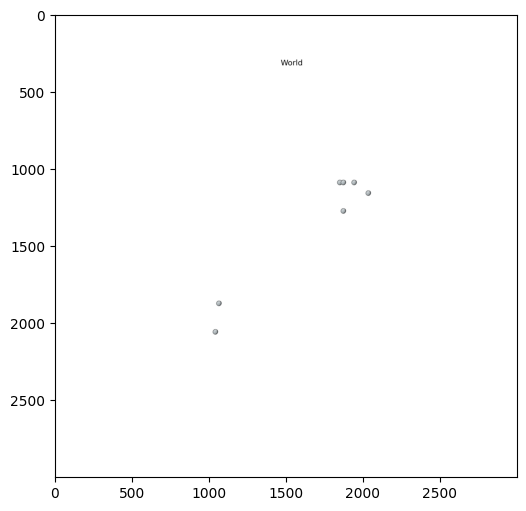

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img)